# Solution to Question 1

## Python imports

Before executing code cells we load some required packages and initiate database connection.

In [2]:
import os # directory pathfinding
if 'notebooks' in os.getcwd(): # make sure jupyter server is in project root
    %cd ..

/Users/sampsa/Projects/rannala_project


In [4]:
import altair as alt # visualization library
import numpy as np  # linear algebra
import pandas as pd  # data processing
from IPython.display import display # show interactive sliders
from ipywidgets import interact # common interactivity features
import ipywidgets as widgets # package for interactivity

# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns
# color = sns.color_palette()

# alt.data_transformers.enable('json') # if number of records > 5000
# alt.renderers.enable('notebook') # Renderer for notebook (comment out if using jupyterlab)

import lib # project code package

AttributeError: module 'pandas' has no attribute 'core'

In [3]:
# create a database connection
database = os.path.realpath('../rannala_project/db/rannala_project.db')
conn = lib.create_connection(database)

## Data Journey

Now we are ready to start exploring the dataset.

### First 5 rows of cleaned dataset

In [4]:
# read in dataset
df = pd.read_sql_query(
    '''SELECT substr(Time,7)||'-'||substr(Time,4,2)||'-'||substr(Time,1,2) as Time,
    cast(replace(Impressions,",","") as INT) as Impressions,cast(replace(Clicks,",","") as INT) as Clicks,
    cast(replace(CTR,"%","") as FLOAT) / 100 as CTR,
    cast(replace([Cohort size],",","") as INT) as [Cohort Size],
    cast(replace([Click to Install],"%","") as FLOAT) as [Click to Install],
    cast(replace(fCVR,"%","") as FLOAT) / 100 as fCVR,
    cast([D7 Payers] as INT) as [D7 Payers],
    cast(replace([D7 Payer Conversion],"%","") as FLOAT) / 100 as [D7 Payer Conversion]
    FROM question1;''', conn)
df.head()

,Time,Impressions,Clicks,CTR,Cohort Size,Click to Install,fCVR,D7 Payers,D7 Payer Conversion
0,2018-09-01,1000593,33371,0.0334,3925,11.8,0.0039,88,0.0224
1,2018-09-02,1235620,38675,0.0313,4425,11.4,0.0036,102,0.0231
2,2018-09-03,1318256,40821,0.0310,4195,10.3,0.0032,82,0.0195
3,2018-09-04,1144845,31356,0.0274,3475,11.1,0.0030,88,0.0253
4,2018-09-05,1159113,34715,0.0299,3205,9.2,0.0028,75,0.0234


### Data types in dataframe

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
Time                   30 non-null object
Impressions            30 non-null int64
Clicks                 30 non-null int64
CTR                    30 non-null float64
Cohort Size            30 non-null int64
Click to Install       30 non-null float64
fCVR                   30 non-null float64
D7 Payers              30 non-null int64
D7 Payer Conversion    30 non-null float64
dtypes: float64(4), int64(4), object(1)
memory usage: 2.2+ KB


## Field descriptions

- **Time**: Date of action (impression, click or install)
- **Impressions**: Number of ad impressions on the given date
- **Clicks**: Number of clicks on the game ad on the given date
- **CTR**: Click through rate
- **Cohort size**: Number of game installs on the given date, which came through ads
- **Click to Install**: Click to Install rate on the given date
- **fCVR**: Funnel conversion rate for the given date, i.e how much of ad impressions turned into a new game install
- **D7 Payers**: Number of players who did an in-app purchase in the game within 7 days after the given install date
- **D7 Payer Conversion**: Share of players who did an in-app purchase within 7 days after installing the game on the given date

### Some basic statistical figures

In [6]:
df.describe()

,Impressions,Clicks,CTR,Cohort Size,Click to Install,fCVR,D7 Payers,D7 Payer Conversion
count,3.000000e+01,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,1.273388e+06,37992.066667,0.029740,3204.666667,8.586667,0.002540,86.833333,0.027330
std,1.571979e+05,7347.102117,0.003603,492.930528,1.312732,0.000425,13.580116,0.003795
min,1.000593e+06,28172.000000,0.024100,2390.000000,6.600000,0.002100,54.000000,0.019500
25%,1.162843e+06,31505.250000,0.027500,2861.000000,7.825000,0.002300,79.250000,0.024025
50%,1.272188e+06,38176.500000,0.029550,3126.000000,8.450000,0.002400,85.500000,0.027500
75%,1.369320e+06,43606.000000,0.031675,3479.500000,9.125000,0.002700,93.500000,0.030225
max,1.642131e+06,57029.000000,0.039200,4425.000000,11.800000,0.003900,118.000000,0.034200


### First impression from data

The pathway from ad views ('impressions') via click'n'installs to players who actually do in-app purchases is very narrow. A million impressions might yield 85 paying customers for example.

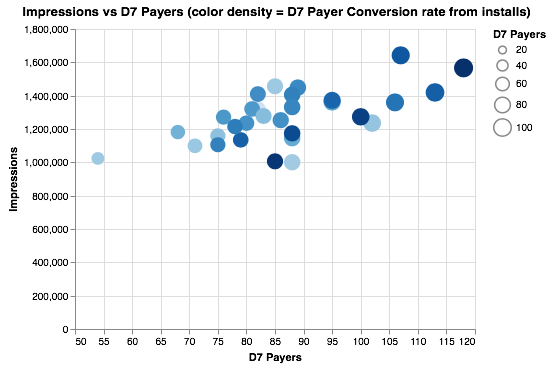

In [7]:
alt.Chart(df).mark_circle().encode(
    alt.Y('Impressions:Q'),
    alt.X('D7 Payers:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('sum(D7 Payer Conversion):Q', legend=None),
    size= 'D7 Payers:Q'
).properties(
    title='Impressions vs D7 Payers (color density = D7 Payer Conversion rate from installs)',
)

### Funnel Part I: Impressions vs Clicks

To travel the rocky path from impressions to paying customers, lets first look at the first step along the way. 8th and 9th of September jump out from data. Both had good conversion rates - even though the number of impressions were not particularly great. 

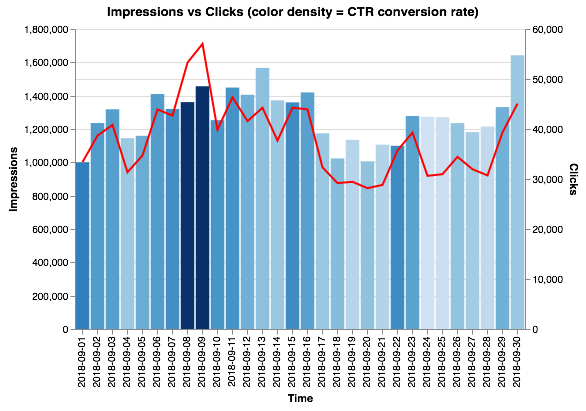

In [8]:
pts = alt.selection(type='interval', encodings=['x'])

base = alt.Chart(df).encode(
    alt.X('Time:N')
)

bar = base.mark_bar().encode(
    y='Impressions:Q',
    color=alt.Color('CTR:Q', legend=None)
).transform_filter(
    pts
).properties(
    selection=pts,
    width=450,
    height=300,
    title='Impressions vs Clicks (color density = CTR conversion rate)'
)

line = base.mark_line(color='red').encode(
    y='Clicks:Q',
)

layer1 = alt.layer(
    bar,
    line
).resolve_scale(
    y='independent', color='independent'
)

layer1

### Funnel Part II: Clicks vs Installs

Here we notice that the start of month was great for landing actual installs from ad clicks. First weekend of September looks like a very good time to be out hunting for new players.

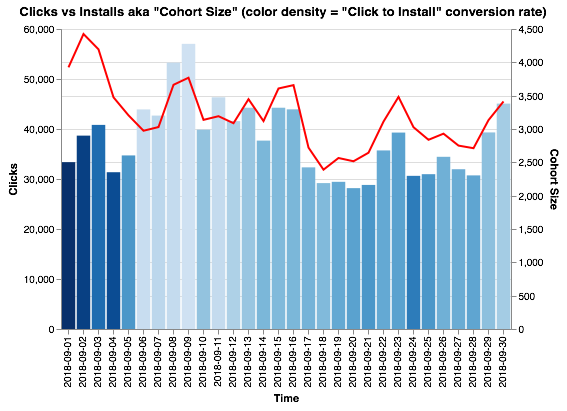

In [9]:
pts = alt.selection(type='interval', encodings=['x'])

base = alt.Chart(df).encode(
    alt.X('Time:N')
)

bar = base.mark_bar().encode(
    y='Clicks:Q',
    color=alt.Color('Click to Install:Q', legend=None)
).transform_filter(
    pts
).properties(
    selection=pts,
    width=450,
    height=300,
    title='Clicks vs Installs aka "Cohort Size" (color density = "Click to Install" conversion rate)'
)

line = base.mark_line(color='red').encode(
    y='Cohort Size:Q',
)

layer1 = alt.layer(
    bar,
    line
).resolve_scale(
    y='independent', color='independent'
)

layer1

### Funnel Parts I & II together form a key KPI

- **fCVR** aka share of ad impressions turned into new game installs.

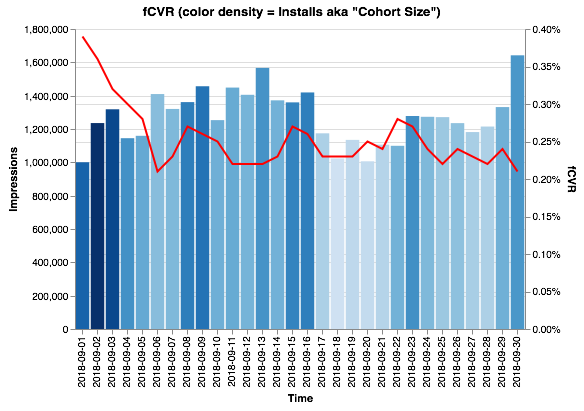

In [10]:
pts = alt.selection(type='interval', encodings=['x'])

base = alt.Chart(df).encode(
    alt.X('Time:N')
)

bar = base.mark_bar().encode(
    alt.Y('Impressions:Q'),
    color=alt.Color('Cohort Size:Q', legend=None)
).transform_filter(
    pts
).properties(
    selection=pts,
    width=450,
    height=300,
    title='fCVR (color density = Installs aka "Cohort Size")'
)

line = base.mark_line(color='red').encode(
    alt.Y('fCVR:Q',axis=alt.Axis(format='%')),
)

layer1 = alt.layer(
    bar,
    line
).resolve_scale(
    y='independent', color='independent'
)





layer1

### Funnel Part III: Installs vs D7 Payers

The share of ad-sourced player cohort that makes in-app purchases within 7 days of game install.

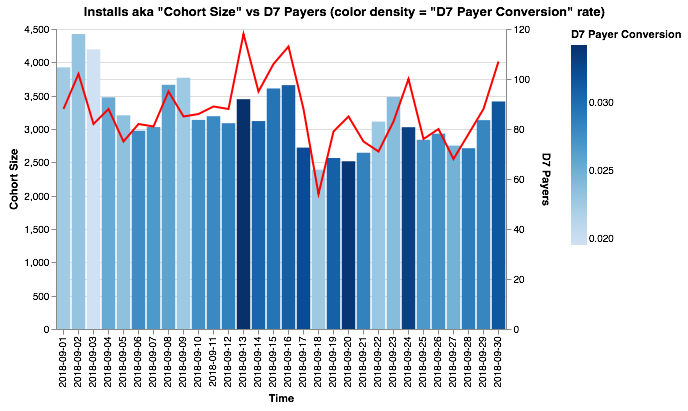

In [11]:
pts = alt.selection(type='interval', encodings=['x'])

base = alt.Chart(df).encode(
    alt.X('Time:N')
)

bar = base.mark_bar().encode(
    y='Cohort Size:Q',
    color=alt.Color('D7 Payer Conversion:Q')
).transform_filter(
    pts
).properties(
    selection=pts,
    width=450,
    height=300,
    title='Installs aka "Cohort Size" vs D7 Payers (color density = "D7 Payer Conversion" rate)'
)

line = base.mark_line(color='red').encode(
    y='D7 Payers:Q',
)

layer1 = alt.layer(
    bar,
    line
).resolve_scale(
    y='independent', color='independent'
)

layer1

### KPI Comparison: CTR vs fCVR vs D7 Payer Conversion Rate aka "D7CVR"

Lets see how the three KPIs match up against each other.

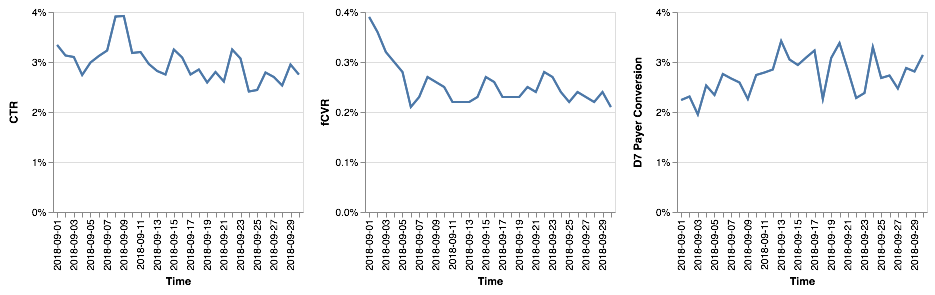

In [12]:

brush = alt.selection(type='interval', encodings=['x'])

# Define the base chart, with the common parts of the
# background and highlights
base = alt.Chart(df).mark_line().encode(
    y=alt.X(alt.repeat('column'), type='quantitative',axis=alt.Axis(format='%')),
    x='Time:O'
).properties(
    width=250,
    height=200
)

# blue background with selection
background = base.properties(
    selection=brush
)

# yellow highlights on the transformed data
highlight = base.encode(
    color=alt.value('bluegreen')
).transform_filter(
    brush
)

# layer the two charts & repeat
alt.layer(
    background, highlight,
    data=df
).repeat(
    column=["CTR", "fCVR", "D7 Payer Conversion"]
)

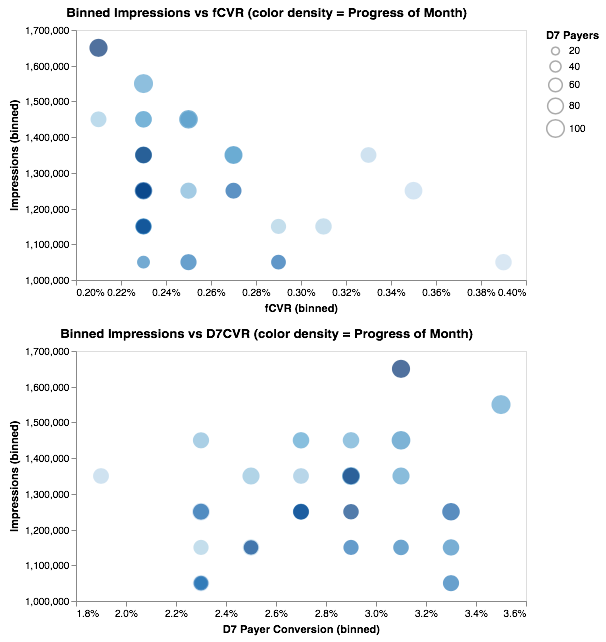

In [13]:
layer1 = alt.Chart(df).mark_circle().encode(
    alt.X('fCVR:Q', bin=True,axis=alt.Axis(format='%')),
    alt.Y('Impressions:Q', bin=True),
    alt.Color('Time:O', legend=None),
    size='D7 Payers'
).properties(
    selection=pts,
    width=450,
    height=250,
    title='Binned Impressions vs fCVR (color density = Progress of Month)'
)

layer2 = alt.Chart(df).mark_circle().encode(
    alt.X('D7 Payer Conversion:Q', bin=True, axis=alt.Axis(format='%')),
    alt.Y('Impressions:Q', bin=True),
    alt.Color('Time:O', legend=None),
    size='D7 Payers'
).properties(
    selection=pts,
    width=450,
    height=250,
    title='Binned Impressions vs D7CVR (color density = Progress of Month)'
)



layer1 & layer2

### Altair Selections Demo

Paint days of month in 1st chart to see filter effect in 2nd chart!

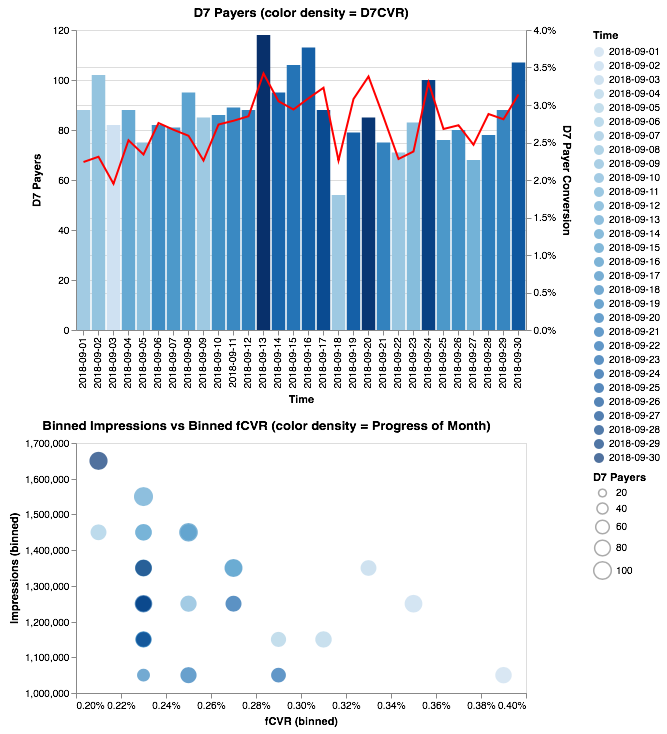

In [14]:
pts = alt.selection(type='interval', encodings=['x'])

base = alt.Chart(df).encode(
    alt.X('Time:O')
)

bar = base.mark_bar().encode(
    y='D7 Payers:Q',
    color=alt.Color('sum(D7 Payer Conversion):Q', legend=None)
).transform_filter(
    pts
).properties(
    selection=pts,
    width=450,
    height=300,
    title='D7 Payers (color density = D7CVR)'
)

line = base.mark_line(color='red').encode(
    alt.Y('D7 Payer Conversion:Q',axis=alt.Axis(format='%'))
)

layer1 = alt.layer(
    bar,
    line
).resolve_scale(
    y='independent', color='independent'
)


layer0 = alt.Chart(df).mark_circle().encode(
    alt.X('fCVR:Q', bin=True, axis=alt.Axis(format='%')),
    alt.Y('Impressions:Q', bin=True),
    color='Time:O',
    size='D7 Payers'
).transform_filter(
    pts
).properties(
    selection=pts,
    width=450,
    height=250,
    title='Binned Impressions vs Binned fCVR (color density = Progress of Month)'
)

layer1 & layer0 

In [1]:
sns.pairplot(df, x_vars=[('Impressions','Clicks','Cohort Size')], y_vars='D7 Payers', height=7, aspect=0.7, kind='reg')

NameError: name 'sns' is not defined

In [66]:
# create a Python list of feature names
feature_cols = ['Impressions', 'Clicks', 'Cohort Size']

# use the list to select a subset of the original DataFrame
X = df[feature_cols]

# equivalent command to do this in one line
# X = df[['Impressions', 'Clicks', 'Cohort Size']]

# print the first 5 rows
X.head()

,Impressions,Clicks,Cohort Size
0,1000593,33371,3925
1,1235620,38675,4425
2,1318256,40821,4195
3,1144845,31356,3475
4,1159113,34715,3205


In [67]:
# check the type and shape of X
print(type(X))
print(X.shape)

<class 'pandas.core.frame.DataFrame'>
(30, 3)


In [68]:
# select a Series from the DataFrame
y = df['D7 Payers']

# equivalent command that works if there are no spaces in the column name
# y = data.Sales

# print the first 5 values
y.head()

0     88
1    102
2     82
3     88
4     75
Name: D7 Payers, dtype: int64

In [69]:
# check the type and shape of y
print(type(y))
print(y.shape)

<class 'pandas.core.series.Series'>
(30,)


In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [71]:
# default split is 75% for training and 25% for testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22, 3)
(22,)
(8, 3)
(8,)


In [72]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [73]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

-11.711974361112624
[ 6.94608989e-05 -7.98629176e-04  1.26142187e-02]


In [74]:
# pair the feature names with the coefficients
list(zip(feature_cols, linreg.coef_))

[('Impressions', 6.946089891007341e-05),
 ('Clicks', -0.0007986291761238135),
 ('Cohort Size', 0.01261421874086751)]

In [75]:
# make predictions on the testing set
y_pred = linreg.predict(X_test)

In [78]:
X_test2 = [[1000000, 15000, 2000]]

In [79]:
# make predictions on new testing set
y_pred2 = linreg.predict(X_test2)

In [80]:
print(y_pred2)

[70.99792439]


In [76]:
from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

9.963401117878089
